<a href="https://colab.research.google.com/github/pensamint/dspl-classification/blob/dev/Classifying_JWST_HST_galaxy_mergers_with_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="top"></a>
# Classifying JWST-HST galaxy mergers with CNNs

<font color="red">This notebook currently fails to execute, use as reference only

SIKE!</font>

***

## Learning Goals


**In this tutorial, you will see an example of building, compiling, and training a CNN on simulated astronomical data.**
By the end of this tutorial you will have a working example of a simple Convolutional Neural Network (CNN) in `Keras`.

## Introduction
CNNs are a class of machine learning (ML) algorithms that can extract information from images.
In this notebook, you will walk through the basic steps of applying a CNN to data:
1. Load the data and visualize a sample of the data.
2. Divide the data into training, validation, and testing sets.
3. Build a CNN in `Keras`.
4. Compile the CNN.
5. Train the CNN to perform a classification task.
6. Evaluate the results.

CNNs can be applied to a wide range of image recognition tasks, including classification and regression.
In this tutorial, we will build, compile, and train CNN to classify whether a galaxy has undergone a merger, using simulated Hubble Space Telescope images of galaxies.
This work is based on the public data and code from <a href='https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract'>DeepMerge (Ciprijanovic et al. 2020)</a>.

**NOTE:** *The DeepMerge team has [publicly-available code](https://github.com/deepskies/deepmerge-public) for demonstrating the architecture and optimal performace of the model, which we encourage you to check out! The goal of this notebook is to step through the model building and training process.*


## Imports
This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:

print("CUDA Version: " + tf.test.gpu_device_name())
print("cuDNN Version: " + str(tf.test.is_built_with_cuda()))

CUDA Version: /device:GPU:0
cuDNN Version: True


In [5]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D  # changes: from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import keras.optimizers as kopt

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn import metrics

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

### 1. Load the data and visualize a sample of the data

Load the simulated galaxy observations (3-band images) and merger probabilities (output labels).

In total, there are 15,426 simulated images, each in three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)), retrieved and augmented from synthetic observations of the Illustris cosmological simulation. The sample includes 8120 galaxy mergers and 7306 non-mergers. Two versions of the sample are available, with and without realistic observational and experimental noise ("pristine" and "noisy"). The sample construction and augmentation process for the HST images is described in detail in [Ciprijanovic et al. 2020](https://doi.org/10.1016/j.ascom.2020.100390), and is identical for the mock JWST images.

These datasets are hosted at the Mikulski Archive for Space Telescopes as an the [DEEPMERGE](https://archive.stsci.edu/doi/resolve/resolve.html?doi=10.17909/t9-vqk6-pc80) high-level science product (HLSP).

The CNN will be trained to distinguish between merging and non-merging galaxies.

#### Load the data

The simulated images are stored in FITS format. We refer you to the [Astropy Documentation](https://docs.astropy.org/en/stable/io/fits/index.html) for further information about this format.

For this example, we will download the "pristine" set of galaxy images, i.e., those without added observational noise. To select the "noisy" sample, change the version below. Alternatively, you can download data files from the [DEEPMERGE](https://stdatu.stsci.edu/hlsp/deepmerge) website.

In [6]:
version = 'pristine'

In [7]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

CPU times: user 2.92 ms, sys: 987 µs, total: 3.91 ms
Wall time: 6.68 ms


Explore the header of the file for information about its contents

In [8]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   75                                                  
NAXIS2  =                   75                                                  
NAXIS3  =                    3                                                  
NAXIS4  =                15426                                                  
EXTEND  =                    T                                                  
NAME1   = 'ImageX  '                                                            
NAME2   = 'ImageY  '                                                            
NAME3   = 'filter  '           / F814W,F356W,F160W                              
NAME4   = 'object  '                                                            
EXTNAME = 'Images  '        

In [9]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                15426 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'MergerLabel'                                                         
TFORM1  = 'D       '                                                            
EXTNAME = 'MergerLabel'                                                         

The file includes a primary header card with overall information, an image card with the simulated images, and a bintable with the merger labels for the images (1=merger, 0=non-merger).

#### Plot example images

For a random selection of images, plot the images and their corresponding labels:

In [10]:
hdu[0].data.shape

(15426, 3, 75, 75)

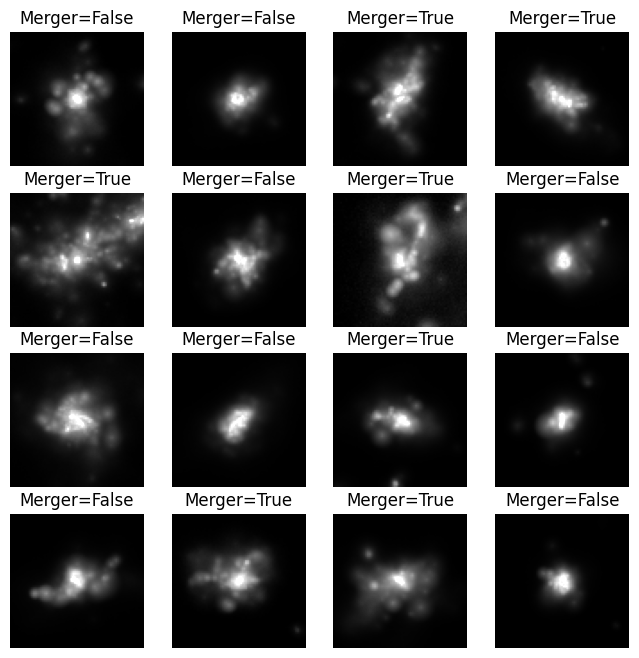

In [11]:
# set the random seed to get the same random set of images each time, or comment it out to get different ones!
# np.random.seed(206265)

# select 16 random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(8, 8))

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    ax.set_title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))

    ax.axis('off')

plt.show()

## 2. Divide data into training, validation, and testing sets

To divide the data set into training, validation, and testing data we will use Scikit-Learn's [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

We will denote the input images as `X` and their corresponding labels (i.e. the integer indicating whether or not they are a merger) as `y`, following the convention used by `sklearn`.

In [12]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test


In [13]:
# as above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

Next, reshape the image array as follows:  (number_of_images, image_width, image_length, 3).
This is referred to as a "channels last" approach, where the final axis denotes the number of "colors" or "channels".
The three-filter images have three channels, similar to RGB images like `jpg` and `png` image formats.
CNN's will work with an arbitrary number of channels.

In [34]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

### 3. Build a CNN in `Keras`

Here, we will build the model described in Section 3 of [Ciprijanovic et al. 2020](https://doi.org/10.1016/j.ascom.2020.100390).

Further details about `Conv2D`, `MaxPooling2D`, `BatchNormalization`, `Dropout`, and Dense layers can be found in the [Keras Layers Documentation](https://keras.io/api/layers/).
Further details about the sigmoid and softmax activation function can be found in the [Keras Activation Function Documentation](https://keras.io/api/layers/activations/).

In [50]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### 4. Compile the CNN

Next, we compile the model.
As in [Ciprijanovic et al. 2020](https://doi.org/10.1016/j.ascom.2020.100390), we select the Adam opmimizer and the binary cross entropy loss function (as this is a binary classification problem).

You can learn more about [optimizers](https://keras.io/api/optimizers/) and more about [loss functions for regression tasks](https://keras.io/api/losses/) in the [Keras documentation](https://keras.io/).

In [51]:
# Compile Model
# optimizer = 'AdamW'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=kopt.RMSprop(), metrics=fit_metrics) #look into
cnn.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 8)         608       
                                                                 
 batch_normalization_12 (Ba  (None, 75, 75, 8)         32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 37, 37, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 37, 37, 8)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 37, 37, 16)        1168

### 5. Train the CNN to perform a classification task

We will start with training for 20 epochs, but this almost certainly won't be long enough to get great results. We set the "batch size" of the network (i.e., the number of samples to be propagated through the network, see the keras documentation [here](https://keras.io/api/models/model_training_apis/)) to 128. Once you've run your model and evaluated the fit, you can come back here and run the next cell again for 100 epochs or longer.
This step will likely take many minutes. The training step is typically the computational bottleneck for using CNNs.
However, once a CNN is trained, it can effectively be "packaged up" for future use on the original or other machines.
In other words, it doesn't have to be retrained every time one wants to use it!

You can learn more about `model.fit` [here](https://keras.rstudio.com/reference/fit.html).

In [52]:
nb_epoch = 100
batch_size = 128
shuffle = True

# Train
history = cnn.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_data=(X_valid, y_valid),
                  shuffle=shuffle,
                  verbose=True)

Epoch 1/100
85/85 [==============================] - 4s 31ms/step - loss: 0.7074 - accuracy: 0.5271 - val_loss: 0.7063 - val_accuracy: 0.5269
Epoch 2/100
85/85 [==============================] - 2s 22ms/step - loss: 0.7051 - accuracy: 0.5271 - val_loss: 0.7043 - val_accuracy: 0.5269
Epoch 3/100
85/85 [==============================] - 2s 21ms/step - loss: 0.7030 - accuracy: 0.5271 - val_loss: 0.7024 - val_accuracy: 0.5269
Epoch 4/100
85/85 [==============================] - 2s 22ms/step - loss: 0.7007 - accuracy: 0.5271 - val_loss: 0.7005 - val_accuracy: 0.5269
Epoch 5/100
85/85 [==============================] - 2s 22ms/step - loss: 0.6979 - accuracy: 0.5271 - val_loss: 0.6978 - val_accuracy: 0.5269
Epoch 6/100
85/85 [==============================] - 2s 23ms/step - loss: 0.6944 - accuracy: 0.5271 - val_loss: 0.6938 - val_accuracy: 0.5269
Epoch 7/100
85/85 [==============================] - 2s 24ms/step - loss: 0.6901 - accuracy: 0.5450 - val_loss: 0.6891 - val_accuracy: 0.5553
Epoch 

### 6. Visualize CNN performance

To visualize the performance of the CNN, we plot the evolution of the accuracy and loss as a function of training epochs, for the training set and for the validation set.

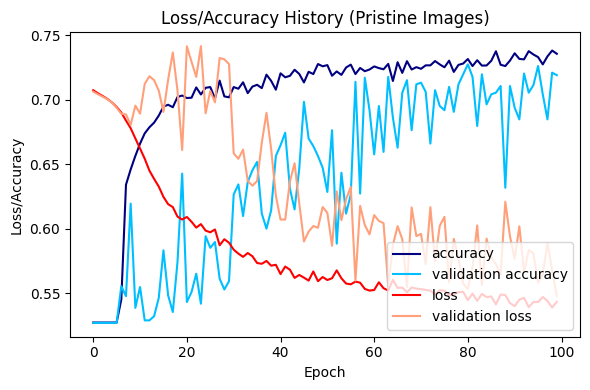

In [53]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.show()

Observe how the loss for the validation set is higher than for the training set (and conversely, the accuracy for the validation set is lower than for the training set), suggesting that this model is suffering from [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). Revisit [the original paper](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract) and notice the strategies they employ to improve the validation accuracy. Observe [their Figure 2](https://www.sciencedirect.com/science/article/pii/S2213133720300445) for an example of what the results of a properly-trained network look like!


### 7. Predict mergers!

Apply the CNN to predict mergers in the "test" set, not used for training or validating the CNN.

In [54]:
test_predictions = cnn.predict(X_test)

97/97 [==============================] - 0s 3ms/step


Below, we use a confusion matrix to evaluate the model performance on the test data. See the documentation from [sklearn on confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for more information.

In [55]:
def plot_confusion_matrix(cnn, input_data, input_labels):

    # Compute merger predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification
    predictions = (predictions > 0.5).astype('int32')

    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results.
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Merger', 'No Merger'])

    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Merger', 'No Merger'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

97/97 [==============================] - 0s 3ms/step


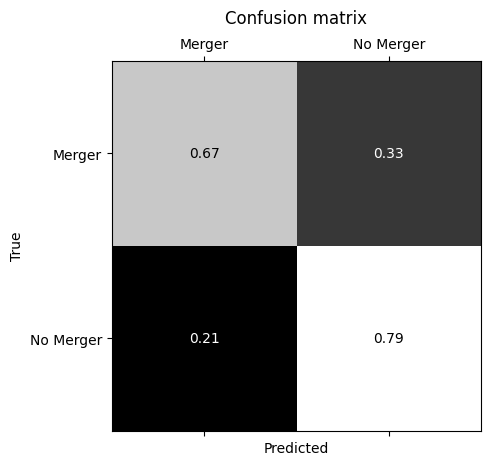

In [56]:
plot_confusion_matrix(cnn, X_test, y_test)

In [57]:
def F1_score(cnn, input_data, input_labels):
    # Compute merger predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification
    predictions = (predictions > 0.5).astype('int32')

    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results.
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]


    # Calculate precision
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])

    # Calculate recall (true positive rate)
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

precision, recall, f1_score = F1_score(cnn, X_test, y_test)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

97/97 [==============================] - 0s 4ms/step
Precision: 0.7229119638826185
Recall: 0.7936802973977695
F1 Score: 0.7566450088600117


In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [59]:

def plot_custom_roc_curve(cnn, input_data, input_labels):
    # Compute merger predictions for the input dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification
    predictions = (predictions > 0.5).astype('int32')

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(input_labels, predictions)

    # Compute the ROC AUC score (Area Under the Curve)
    roc_auc = roc_auc_score(input_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


97/97 [==============================] - 0s 3ms/step


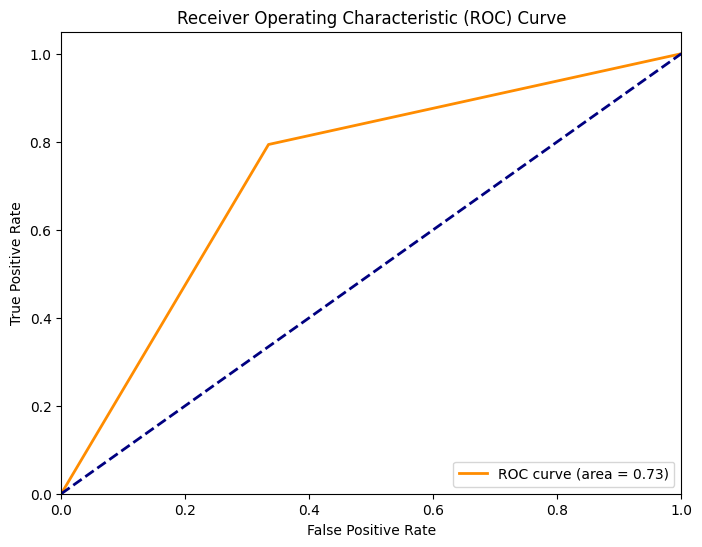

In [60]:
plot_custom_roc_curve(cnn, X_test, y_test)

## FAQ

- **How do I interpret theses results?** The confusion matrix shows the model predicts a large fraction of false positive (roughly 25%) and false negative (roughly 36%) merger events. The published models from [Ciprijanovic et al. 2020](https://doi.org/10.1016/j.ascom.2020.100390) perform much better.  We note that in this notebook we are training for only a subset of the optimal number of epochs for space and time considerations, but you are welcome to agument these restricitons, and as always check out [the DeepMerge code](https://github.com/deepskies/deepmerge-public) for more information!


- **Can I improve the model by changing it?** We only trained for 20 epochs, which is many fewer than the published model. Go back to Section 4 ("Train the CNN to perform a classification task") and increase the number of epochs to 100 (or more!) and train again. Does your model perform better? Your results may look better/worse/different from the published results due to the stochastic nature of training.


- **Can I try a different model?  I think the results could be improved.** Yes!  You can try adding layers, swapping out the max pooling, changing the activation functions, swapping out the loss function, or trying a different optimizer or learning rate.  Experiment and see what model changes give the best results. You should be aware:  when you start training again, you pick up where your model left off.  If you want to "reset" your model to epoch 0 and random weights, you should run the cells to make and compile the model again.


- **I want to test my model on my training data!** No. You will convince yourself that your results are much better than they actually are.  Always keep your training, validation, and testing sets completely separate!


### Extensions/Exercises

- **Effect of noise?** Try re-training the network with "noisy" data (i.e., modify the `version` in Section 1 to "noisy" and download the associated data product). Do the results change? If so, how and why? What are the pros and cons of using noisy vs. pristine data to train a ML model?



- **Effect of wavelength?** The [DEEPMERGE HLSP](https://archive.stsci.edu/doi/resolve/resolve.html?doi=10.17909/t9-vqk6-pc80) includes mock galaxy images in 2 filters only (only HST data). If you train the network with this data (hint: this will require downloading it from the website, or modifying the download cells to point to the correct URL; and also modifying the shapes of the training, validation and test data, as well as the network inputs), how do the results change?



- **Early stopping?** The DeepMerge team employed "early stopping" to minimize overfitting. Try implementing it in the network here! The Keras library for [early stopping](https://keras.io/api/callbacks/early_stopping/) functions will be useful. For example, you can recompile the model, train for many more epochs, and include a `callback`, in `cnn.train` e.g.,

    `callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)`
    

*Don't forget, [the DeepMerge team provides code](https://github.com/deepskies/deepmerge-public) for building their production-level model and verifying its results, please check them out for more extensions and ideas!*


## About this Notebook

**Author:**  
Claire Murray, Assistant Astronomer, cmurray1@stsci.edu  

**Additional Contributors:**  
Yotam Cohen, STScI Staff Scientist, ycohen@stsci.edu

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.

**Updated On:** 2022-5-25

## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)



[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>